<a href="https://colab.research.google.com/github/J-oyin/Dr.-Jimoh-Analysis/blob/main/Food_intake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install statannotations


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

In [49]:
data = pd.read_excel("/content/Dr.J_Food_intake.xlsx")

In [50]:
data.head()

,S/N,Group,Food_intake,conditions,Subject
0,1,Healthy,14,baseline,RC1
1,2,Healthy,14,baseline,RC2
2,3,Healthy,12,baseline,RC3
3,4,Healthy,14,baseline,RC4
4,5,Healthy,17,baseline,RC5


In [51]:
from scipy.stats import levene

grouped = [data[data['Group']==grp]['Food_intake'].values for grp in
           ['Healthy', 'Resilient', 'S/DW', 'S/RG108', 'S/Esc',
            'S/LASA', 'S/LASA+ESC', 'S/HASA', 'S/HASA+ESC']]

stat, p = levene(*grouped)
print(f"Levene Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Variances are homogeneous across groups")
else:
    print("Variances are NOT homogeneous across groups")


Levene Test: stat=nan, p=nan
Variances are NOT homogeneous across groups


/tmp/ipython-input-2199785571.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = levene(*grouped)


In [52]:
df = data

In [53]:
df.head(10)

,S/N,Group,Food_intake,conditions,Subject
0,1,Healthy,14,baseline,RC1
1,2,Healthy,14,baseline,RC2
2,3,Healthy,12,baseline,RC3
3,4,Healthy,14,baseline,RC4
4,5,Healthy,17,baseline,RC5
5,6,Healthy,12,post.indt,RC1
6,7,Healthy,18,post.indt,RC2
7,8,Healthy,14,post.indt,RC3
8,9,Healthy,14,post.indt,RC4
9,10,Healthy,14,post.indt,RC5


In [54]:
from scipy.stats import friedmanchisquare

# Convert 'Food_intake' to numeric, coercing errors
df['Food_intake'] = pd.to_numeric(df['Food_intake'], errors='coerce')

# Create an empty list to collect results
results = []

# Loop over each group and run the Friedman test
for grp, data in df.groupby('Group'):
    # Pivot data so each condition becomes a column (subjects as rows)
    pivot = data.pivot(index='Subject', columns='conditions', values='Food_intake')

    # Ensure conditions are in correct order and drop rows with NaN values
    pivot = pivot[['baseline', 'post.indt', 'post.tret']].dropna()

    # Check if there's enough data after dropping NaNs
    if len(pivot) < 1:
        print(f"Skipping Friedman test for group {grp} due to insufficient data after dropping NaNs.")
        continue

    # Run Friedman test
    stat, p = friedmanchisquare(pivot['baseline'], pivot['post.indt'], pivot['post.tret'])

    # Save results
    results.append({'Group': grp, 'Chi-square': stat, 'p-value': p})

# Convert results to dataframe
friedman_results = pd.DataFrame(results)
print(friedman_results)

       Group  Chi-square   p-value
0    Healthy    0.875000  0.645649
1  Resilient    4.777778  0.091732
2       S/DW    3.444444  0.178669
3      S/Esc    7.600000  0.022371
4     S/HASA    2.000000  0.367879
5     S/LASA    0.400000  0.818731


In [55]:

# ------- choose outcome variable -------
dv = 'Food_intake'   # change this to any measure you like

# ------- function to build the table -------
def make_desc_table(data, group_cols, dv):
    g = data.groupby(group_cols)[dv]

    desc = g.agg(
        N='count',
        Mean='mean',
        SD='std',
        SEM=lambda x: x.std(ddof=1) / np.sqrt(x.count()),
        Median='median',
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75),
        Min='min',
        Max='max'
    ).reset_index()

    # IQR
    desc['IQR'] = desc['Q3'] - desc['Q1']

    # round for manuscript
    num_cols = ['Mean', 'SD', 'SEM', 'Median', 'Q1', 'Q3', 'IQR', 'Min', 'Max']
    desc[num_cols] = desc[num_cols].round(2)

    # formatted columns often reported in papers
    desc['Mean ± SD'] = desc['Mean'].astype(str) + ' ± ' + desc['SD'].astype(str)
    desc['Median (IQR)'] = (
        desc['Median'].astype(str) + ' (' +
        desc['Q1'].astype(str) + '–' +
        desc['Q3'].astype(str) + ')'
    )

    # column order
    cols_order = (
        group_cols +
        ['N', 'Mean', 'SD', 'SEM', 'Mean ± SD',
         'Median', 'Q1', 'Q3', 'IQR', 'Median (IQR)', 'Min', 'Max']
    )
    desc = desc[cols_order]

    return desc

# ------- build table: per Group × Condition -------
group_cols = ['Group', 'conditions']   # change if you want only Group, etc.
desc_table = make_desc_table(df, group_cols, dv)

print(desc_table)

# ------- export to Excel -------
output_file = f"Descriptive_stats_{dv}.xlsx"
desc_table.to_excel(output_file, index=False)
print("Saved to:", output_file)


        Group conditions  N  Mean    SD   SEM    Mean ± SD  Median    Q1  \
0     Healthy   baseline  5  14.2  1.79  0.80  14.2 ± 1.79    14.0  14.0   
1     Healthy  post.indt  5  14.4  2.19  0.98  14.4 ± 2.19    14.0  14.0   
2     Healthy  post.tret  5  13.6  1.14  0.51  13.6 ± 1.14    14.0  13.0   
3   Resilient   baseline  5  19.0  4.53  2.02  19.0 ± 4.53    17.0  17.0   
4   Resilient  post.indt  5  14.0  2.12  0.95  14.0 ± 2.12    14.0  13.0   
5   Resilient  post.tret  5  17.6  7.30  3.26   17.6 ± 7.3    15.0  13.0   
6        S/DW   baseline  5  16.0  2.00  0.89   16.0 ± 2.0    15.0  15.0   
7        S/DW  post.indt  5  13.6  2.30  1.03   13.6 ± 2.3    14.0  13.0   
8        S/DW  post.tret  5  13.0  1.87  0.84  13.0 ± 1.87    12.0  12.0   
9       S/Esc   baseline  5  17.8  1.48  0.66  17.8 ± 1.48    18.0  17.0   
10      S/Esc  post.indt  5  12.6  1.82  0.81  12.6 ± 1.82    13.0  12.0   
11      S/Esc  post.tret  5  12.8  2.17  0.97  12.8 ± 2.17    13.0  12.0   
12     S/HAS

/tmp/ipython-input-2880188372.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


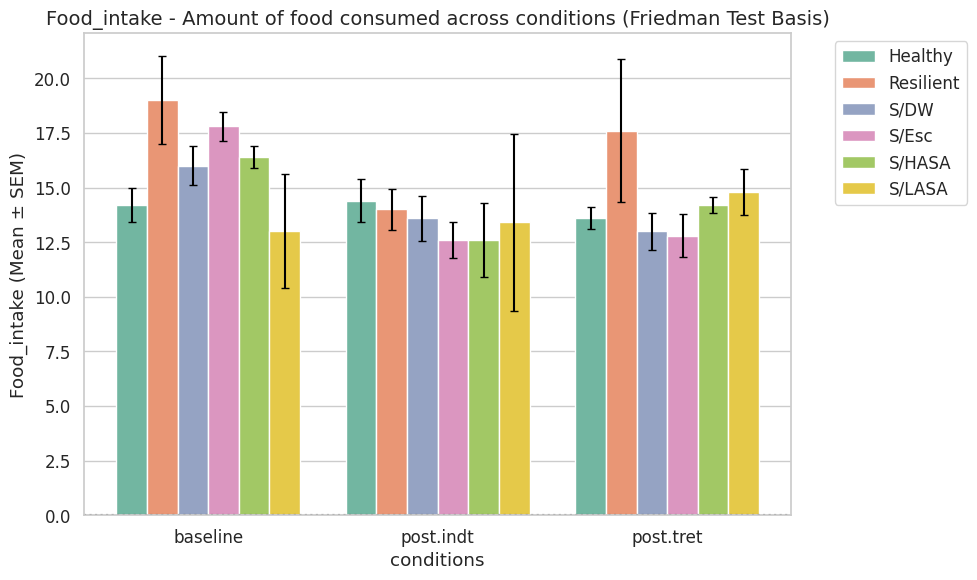

In [56]:
summary = (
    df.groupby(['Group', 'conditions'])['Food_intake']
      .agg(['mean', 'sem'])
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.1)

# Create the barplot (mean values)
ax = sns.barplot(
    data=summary,
    x='conditions',
    y='mean',
    hue='Group',
    ci=None,  # we are providing our own SEM
    capsize=0.1,
    palette='Set2'
)

for i, row in summary.iterrows():
    group_index = list(summary['Group'].unique()).index(row['Group'])
    cond_index = list(summary['conditions'].unique()).index(row['conditions'])
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width()/2
    y = row['mean']
    plt.errorbar(x, y, yerr=row['sem'], fmt='none', ecolor='black', capsize=3)

plt.title("Food_intake - Amount of food consumed across conditions (Friedman Test Basis)", fontsize=14)
plt.ylabel("Food_intake (Mean ± SEM)")
plt.xlabel("conditions")
plt.axhline(color='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


In [61]:
from scipy.stats import wilcoxon
import itertools

# Filter only the three groups
groups_of_interest = ['S/Esc']
df_sub = df[df['Group'].isin(groups_of_interest)]


In [62]:
data_group = df[df['Group'] == 'Healthy']
data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Food_intake')
print("Pivot columns:", data_pivot.columns)


Pivot columns: Index(['baseline', 'post.indt', 'post.tret'], dtype='object', name='conditions')


In [63]:
import itertools
from scipy.stats import wilcoxon

condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))
results = []

for g in ['S/Esc']:
    data_group = df[df['Group'] == g]
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Food_intake')

    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()
            stat, p = wilcoxon(valid[cond1], valid[cond2])
            results.append({'Group': g, 'Comparison': f'{cond1} vs {cond2}', 'Statistic': stat, 'p-value': p})
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

import pandas as pd
posthoc_df = pd.DataFrame(results)
print(posthoc_df)


   Group              Comparison  Statistic  p-value
0  S/Esc   baseline vs post.indt        0.0   0.0625
1  S/Esc   baseline vs post.tret        0.0   0.0625
2  S/Esc  post.indt vs post.tret        7.0   1.0000


Pairs used: []
P-values: []


/tmp/ipython-input-527870520.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-527870520.py:35: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(


ValueError: pairs are empty after parsing: original_pairs=[]
not in group_list=[('S/Esc', 'baseline'), ('S/Esc', 'post.indt'), ('S/Esc', 'post.tret')]

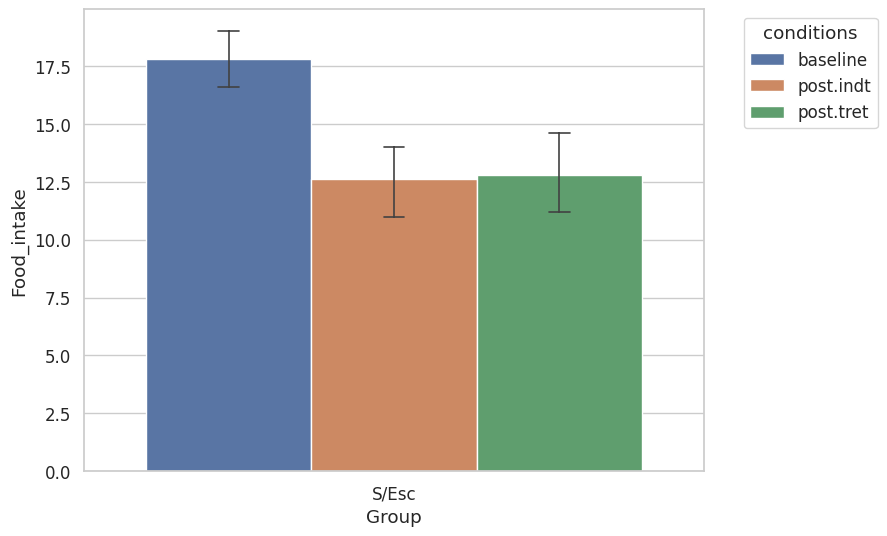

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# ── 0. If you have Holm-corrected p-values, set the column name here ──
p_col = 'p-Holm' if 'p-Holm' in posthoc_df.columns else 'p-value'

# ── 1. Split "baseline vs post.indt" into 2 condition columns ──
posthoc_df[['cond1', 'cond2']] = posthoc_df['Comparison'].str.split(' vs ', expand=True)

# ── 2. Keep only significant comparisons (you can change alpha if you like) ──
alpha = 0.05
sig_df = posthoc_df[posthoc_df[p_col] < alpha]

# ── 3. Build `pairs` and `p_values` for statannotations ──
pairs = []
p_values = []

for _, row in sig_df.iterrows():
    g = row['Group']
    c1 = row['cond1']
    c2 = row['cond2']

    # pair format is: ((x, hue), (x, hue))
    pairs.append(((g, c1), (g, c2)))
    p_values.append(row[p_col])

print("Pairs used:", pairs)
print("P-values:", p_values)

# ── 4. Plot the bars ──
plot_df = df[df['Group'].isin(['S/Esc'])]

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x='Group', y='Food_intake', hue='conditions',
    ci=95, capsize=0.1, errwidth=1.2
)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='conditions')

# ── 5. Add significance stars from the pairs + p_values ──
annot = Annotator(
    ax,
    pairs,
    data=plot_df,
    x='Group',
    y='Food_intake',
    hue='conditions'
)
annot.configure(test=None, text_format='star', loc='inside', verbose=2)
annot.set_pvalues(p_values)
annot.annotate()

plt.title('Post Hoc Comparison Across Conditions')
plt.xlabel('Group')
plt.ylabel('Food_intake (mean ± CI)')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Filter only the three groups used in post hoc analysis
plot_df = df[df['Group'].isin(['S/DW', 'S/HASA', 'S/RG108'])]

# Set up figure
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x='Group', y='Time_in_open_arm', hue='conditions',
    ci=95, capsize=0.1, errwidth=1.2
)

# Move legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Group')

# Define your post hoc pairs and p-values (update with your actual results)
pairs = pairs = [
    (("S/DW", "baseline"), ("S/DW", "post.indt")),
    (("S/HASA", "baseline"), ("S/HASA", "post.tret")),
    (("S/RG108", "baseline"), ("S/RG108", "post.tret"))
]
p_values = [0.02, 0.01, 0.03]  # replace with your actual post hoc p-values

# Add significance stars
annot = Annotator(ax, pairs, data=plot_df, x='Group', y='Time_in_open_arm', hue='conditions')
annot.configure(test=None, text_format='star', loc='inside', verbose=2)
annot.set_pvalues(p_values)
annot.annotate()

# Beautify the plot
plt.title('Post Hoc Comparison Across Conditions')
plt.xlabel('Conditions')
plt.ylabel('Behavioral Measure (mean ± CI)')
plt.tight_layout()
plt.show()
